In [11]:
import numpy
import scipy
import matplotlib
import matplotlib.pyplot as plt
from copy import copy
import os

# Fetch Neo, Elephant
import neo
import neo.io.nestio as nestio
import elephant
import quantities as pq
import numpy as np

# Import prototype Viziphant
import sys
# sys.path.insert(0, "/home/denker/Projects/viziphant")
sys.path.insert(0, "/home/robin/Projects/viziphant")
import viziphant.rasterplot

# sys.path.insert(0, "/home/denker/Projects/toolboxes/py/NetworkUnit")
sys.path.insert(0, "/home/robin/Projects/NetworkUnit")
import sciunit
from networkunit import scores, models, tests, plots
from networkunit.scores import to_precision

%matplotlib inline

## Define model classes
#### WavescalES class

In [2]:
class wavescales_data(models.spiketrain_data):
    file_path = None
    params = {'gridsize':(24,24),
              'filter_dpsnn_ids':[],
              'filter_nest_ids':[],
              'filter_type':None,
              'filter_module':None,
              'align_to_0':False
             }
    
    def filter_type(self, spiketrains, filter_type=None, **kwargs):
        if type(filter_type) == str:
            filter_type = [filter_type]
        spiketrains = list(filter(lambda st: st.annotations['sub_population'] 
                                   in filter_type, spiketrains))
        return spiketrains
    
    def filter_module(self, spiketrains, filter_module=None, **kwargs):
        if type(filter_module) == int:
            filter_module = [filter_module]
        spiketrains = list(filter(lambda st: st.annotations['grid_position'][0]*self.params['gridsize'][0] 
                                           + st.annotations['grid_position'][1]
                                       in filter_module, spiketrains))
        return spiketrains
    
    def mapping(self, nest_id=None, dpsnn_id=None):
        A = self.params['gridsize'][0]
        B = self.params['gridsize'][1]

        if nest_id is not None and dpsnn_id is None:
            type_separator = (nest_id-2) // (A*B)
        elif dpsnn_id is not None and nest_id is None:
            type_separator = dpsnn_id % 1250
        else:
            raise ValueError('Only pass either a NEST id or a DPSNN id!')

        if type_separator < 250:
            subpop = 'EXF'
            subpopsize = 250
            typeID = 0
        elif type_separator < (250+750):
            subpop = 'EXB'
            subpopsize = 750
            typeID = 250
        else:
            subpop = 'INH'
            subpopsize = 250
            typeID = 250+750
            
        nest_shift = 2 + typeID * A*B          

        if nest_id is not None and dpsnn_id is None:
            intypeID = nest_id - nest_shift
            insubpopID = intypeID % subpopsize # [0, subpopsize]
            grid_num = intypeID // subpopsize # [0,AxB]  == a + b*A
            dpsnn_id = 1250 * grid_num + insubpopID + typeID
            
        elif dpsnn_id is not None and nest_id is None:
            insubpopID = type_separator - typeID
            grid_num = dpsnn_id // 1250    # [0,AxB]
            nest_id = nest_shift + subpopsize*grid_num + insubpopID    

        a = grid_num % A         # [0,A]
        b = grid_num // A        # [0,B]
        return (dpsnn_id, nest_id, subpop, (a,b))

#### DPSNN class

In [3]:
class dpsnn_wavescales_data(wavescales_data):
    file_path = None
    params = copy(wavescales_data.params)

    def load(self, file_path, filter_dpsnn_ids=[], filter_nest_ids=[], filter_type=None, filter_module=None, **kwargs):
        if filter_nest_ids and not filter_dpsnn_ids:
            filter_dpsnn_ids = [self.mapping(nest_id=i)[1] for i in filter_nest_ids]
        if filter_type is not None or filter_module is not None:
            if not filter_dpsnn_ids:
                filter_dpsnn_ids = list(range(1250*self.gridsize[0]*self.gridsize[1]))
            if filter_type is not None:
                filter_dpsnn_ids = list(filter(lambda i: self.mapping(dpsnn_id=i)[2] in filter_type, filter_dpsnn_ids))
        if filter_module is not None:
                filter_dpsnn_ids = list(filter(lambda i: self.mapping(dpsnn_id=i)[3][0]*self.gridsize[0]
                                                       + self.mapping(dpsnn_id=i)[3][1] in filter_module, filter_dpsnn_ids))
        neo_obj = nestio.NestIO(file_path)
        neo_block = neo_obj.read_block(gid_list=filter_dpsnn_ids, t_start = 0*pq.s, t_stop = 10*pq.s)
        spiketrains = neo_block.segments[0].spiketrains
        for st_count, st in enumerate(spiketrains):
                dpsnn_id, nest_id, subpop, gridpos = self.mapping(dpsnn_id=st.annotations['id'])
                spiketrains[st_count].annotate(dpsnn_id = dpsnn_id)
                spiketrains[st_count].annotate(sub_population = subpop)
                spiketrains[st_count].annotate(grid_position = gridpos)
                spiketrains[st_count].annotate(nest_id = nest_id) 
#         spiketrains = list(filter(lambda st: st.any(), spiketrains))
        return spiketrains

    
#     def mapping(self, dpsnn_id):
#         A = self.params['gridsize'][0]
#         B = self.params['gridsize'][1]
#         type_separator = dpsnn_id % 1250
        
#         if type_separator < 250:  # 0 - 249
#             subpop = 'EXF'
#             nest_offset = 2
#             subpopsize = 250
#             insubpopID = type_separator
#         elif type_separator < 250 + 750: # 250 - 999
#             subpop = 'EXB'
#             nest_offset = 2 + 250 * A*B
#             subpopsize = 750
#             insubpopID = type_separator - 250
#         else:  # 1000 - 1249 
#             subpop = 'INH'
#             nest_offset = 2 + (250+750) * A*B
#             subpopsize = 250
#             insubpopID = type_separator - (250+750)
            
#         grid_num = dpsnn_id // 1250    # [0,AxB]
#         a = grid_num % A         # [0,A]
#         b = grid_num // A        # [0,B]
        
#         nest_id = nest_offset + subpopsize*grid_num + insubpopID 
        
#         return (dpsnn_id, nest_id, subpop, (a,b))

#### NEST class

In [4]:
class nest_wavescales_data(wavescales_data):
    file_path = None
    params = copy(wavescales_data.params)
    
    # ToDo: employ options for selective loading 
    # (random samples, neuron-type filters, ...)
    def load(self, file_path, filter_dpsnn_ids=[], filter_nest_ids=[], filter_type=None, filter_module=None, **kwargs):
        if os.path.isfile(file_path):
            dir_path, filename = os.path.split(file_path)
            dir_path = dir_path + '/'
            file_names = [filename]
        elif os.path.isdir(file_path):
            dir_path = file_path + '/'
            file_names = []
            for name in os.listdir(file_path):
                if name.split('.')[-1] == 'gdf':
                    file_names += [name]
        else:
            raise ImportError('No valid file path provided!')
                    
        spiketrain_list = []
        
        if filter_dpsnn_ids and not filter_nest_ids:
            filter_nest_ids = [self.mapping(dpsnn_id=i)[1] for i in filter_dpsnn_ids]
        if filter_type is not None or filter_module is not None:
            if not filter_nest_ids:
                filter_nest_ids = list(range(1250*self.gridsize[0]*self.gridsize[1]))
            if filter_type is not None:
                filter_nest_ids = list(filter(lambda i: self.mapping(nest_id=i)[2] in filter_type, filter_nest_ids))
            if filter_module is not None:
                filter_nest_ids = list(filter(lambda i: self.mapping(nest_id=i)[3][0]*self.gridsize[0]
                                                       + self.mapping(nest_id=i)[3][1] in filter_module, filter_nest_ids))
                                        
        for fname in file_names:
            neo_obj = nestio.NestIO(dir_path + fname)
            neo_block = neo_obj.read_block(gid_list=filter_nest_ids, t_start = 0*pq.s, t_stop = 10*pq.s) 
            # ToDo: Can read_block accept gids which are not in the file??
            spiketrains = neo_block.segments[0].spiketrains
            for st_count, st in enumerate(spiketrains): 
                dpsnn_id, nest_id, subpop, gridpos = self.mapping(nest_id=st.annotations['id'])
                spiketrains[st_count].annotate(dpsnn_id = dpsnn_id)
                spiketrains[st_count].annotate(sub_population = subpop)
                spiketrains[st_count].annotate(grid_position = gridpos)
                spiketrains[st_count].annotate(nest_id = nest_id)
                
            spiketrain_list = spiketrain_list + spiketrains
        spiketrain_list = list(filter(lambda st: st.any(), spiketrain_list))
         # ToDo: remove duplicates, keep empty spike trains

#         if filter_type is not None:
#             spiketrain_list = self.filter_type(spiketrain_list, filter_type)
#         if filter_module is not None:
#             spiketrain_list = self.filter_module(spiketrain_list, filter_module)
        return spiketrain_list

#     def mapping(self, nest_id):
#         A = self.params['gridsize'][0]
#         B = self.params['gridsize'][1]
#         type_separator = (nest_id-2)
        
#         if type_separator < 250 * A*B:
#             subpop = 'EXF'
#             intypeID = type_separator
#             subpopsize = 250
#         elif type_separator < (250+750) * A*B:
#             subpop = 'EXB'
#             intypeID = type_separator - 250 * A*B
#             subpopsize = 750
#         else:
#             subpop = 'INH'
#             intypeID = type_separator - (250+750) * A*B
#             subpopsize = 250
            
#         grid_num = intypeID // subpopsize # [0,AxB]  == a + b*A
#         insubpopID = intypeID % subpopsize # [0, subpopsize]
#         inmoduleID = - int((intypeID - type_separator) / (A*B))
#         a = grid_num % A          # [0,A]
#         b = grid_num // A         # [0,B]
        
#         dpsnn_id = 1250 * grid_num + insubpopID + inmoduleID
        
#         return (dpsnn_id, nest_id, subpop, (a,b))

## Set parameters and initialize models

In [5]:
data_path = './data/'

class NEST(nest_wavescales_data):
    file_path = data_path + "NEST/"#spikeTotal-721206-000.gdf"
    params = copy(nest_wavescales_data.params)
    params.update(color='#FF6634')
#     params.update(filter_dpsnn_ids=[1,2,3,4,5])
    params.update(filter_type='EXF', filter_dpsnn_ids=list(range(1300)))
    

class DPSNN(dpsnn_wavescales_data):
    file_path = data_path + "DPSNN/spikesDPSNN_24x24_SW06.gdf"
    params = copy(dpsnn_wavescales_data.params)
    params.update(color='#1B6145')
    params.update(filter_type='EXF', filter_dpsnn_ids=list(range(1300)))

In [6]:
nest = NEST(name='NEST Implementation')
dpsnn = DPSNN(name='DPSNN Implementation')

In [7]:
nest.produce_spiketrains()
dpsnn.produce_spiketrains();

In [8]:
print(len(nest.spiketrains), len(dpsnn.spiketrains))

212 300


In [12]:
print(np.sort([st.annotations['nest_id'] for st in nest.spiketrains]))

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 288 289 290 291 292 293 294 295 296 297 298 299 300 301]


## Show rasterplots

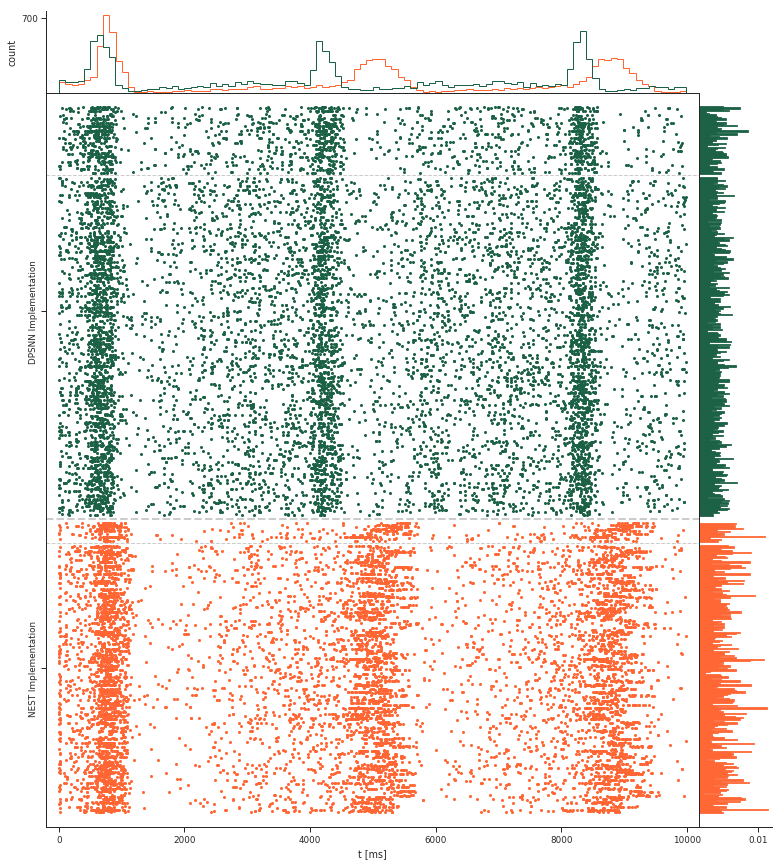

In [31]:
fig, ax = plt.subplots(figsize=(13,15))

viziphant.rasterplot.rasterplot([nest.spiketrains, dpsnn.spiketrains], 
                                key_list=['', 'grid_position', 'sub_population'], 
                                colorkey='',
                                legend=False,
                                ax=ax,
                                groupingdepth=2,
                                spacing=5,
                                labelkey='',
                                palette=[nest.params['color'], dpsnn.params['color']]);

ax.set_yticklabels([nest.name, dpsnn.name], rotation=90, va='center');

## Define tests

In [23]:
class fr_test(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.kl_divergence # ks_distance, mwu_statistic, effect_size
    params = {'binsize': 2*pq.ms,
              'kl_binsize':0.1}
    
    def compute_score(self, prediction1, prediction2):
        score = self.score_type.compute(prediction1, prediction2, **self.params)
        return score

frtest = fr_test()

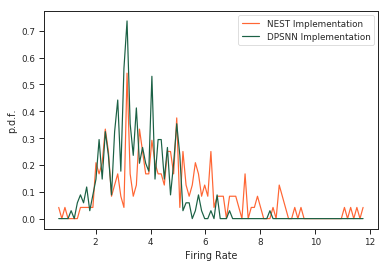

In [24]:
frtest.visualize_samples(nest, dpsnn, var_name='Firing Rate')
plt.show()

In [25]:
score = frtest.judge([nest, dpsnn]).iloc[0,1]
print(score)



Kullback-Leibler-Divergence
	datasize: 212 	 300
	discarded: 64
	D_KL = 0.474 	 bins = 110




/home/robin/anaconda3/envs/py37/lib/python3.7/site-packages/sciunit/scores/collections_m2m.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.models = models


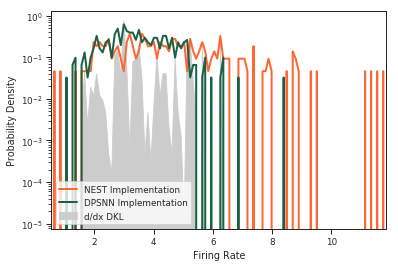

In [26]:
frtest.visualize_score(nest, dpsnn, var_name='Firing Rate')
plt.show()